<a href="https://colab.research.google.com/github/DheerajKP1/15-puzzle/blob/master/yolov8_seg%20v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
import imutils
import math
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import save_model

In [ ]:
'''!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="1noAejnCZB0LPk6DA1o5")
project = rf.workspace("iit-kgp-hddfw").project("tyre-ylryk")
dataset = project.version(5).download("yolov8")'''

'!pip install roboflow\n\nfrom roboflow import Roboflow\nrf = Roboflow(api_key="1noAejnCZB0LPk6DA1o5")\nproject = rf.workspace("iit-kgp-hddfw").project("tyre-ylryk")\ndataset = project.version(5).download("yolov8")'

In [ ]:
'''from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n-seg.pt')  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data='/content/tyre-5/data.yaml', epochs=100, imgsz=640)'''

"from ultralytics import YOLO\n\n# Load a model\nmodel = YOLO('yolov8n-seg.pt')  # load a pretrained model (recommended for training)\n\n# Train the model\nresults = model.train(data='/content/tyre-5/data.yaml', epochs=100, imgsz=640)"

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.8/677.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
path='/content/drive/MyDrive/original_tyre/127.jpg'

model=YOLO('/content/drive/MyDrive/yolov8-seg/segment/train2/weights/best.pt')
result=model(path,save=True,save_txt=True)[0]
input_img=result.orig_img
if result.masks==None:
  print('roi not find')
  plt.imshow(input_img)
else :
  result=model(path,save=True,save_txt=True,conf=float('{:.2f}'.format(result[0].boxes.conf.item()))-0.01)[0]

input_img=result.orig_img
o_path=f"{result.save_dir}/{path.split('/')[-1]}"
masked_img=plt.imread(o_path)


image 1/1 /content/drive/MyDrive/original_tyre/127.jpg: 640x480 2 rois, 191.7ms
Speed: 4.0ms preprocess, 191.7ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict8
1 label saved to runs/segment/predict8/labels

image 1/1 /content/drive/MyDrive/original_tyre/127.jpg: 640x480 1 roi, 208.6ms
Speed: 3.8ms preprocess, 208.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict8
1 label saved to runs/segment/predict8/labels


<ipython-input-32-7f69bf7763cf>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


Text(0.5, 1.0, 'Masked_img')

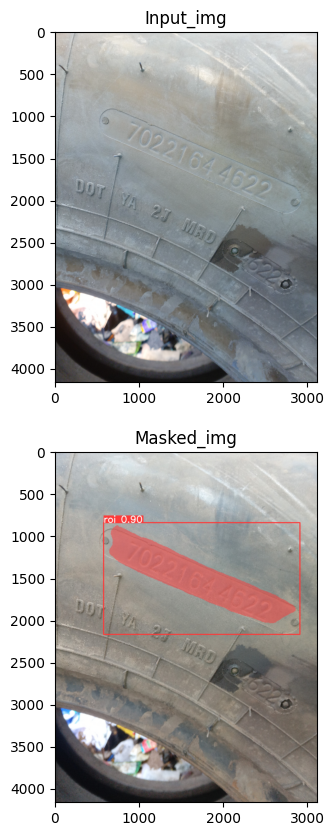

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(masked_img)
plt.subplot(2,1,1)
plt.imshow(input_img)
plt.title('Input_img')
plt.subplot(2,1,2)
plt.imshow(masked_img)
plt.title('Masked_img')

In [ ]:
H,W,_=masked_img.shape
print(H,W)

4160 3120


In [ ]:
for j,mask in enumerate(result.masks.data):
  #mask=mask.cuda()
  mask=mask.cpu().numpy()*255
  mask=cv.resize(mask,(W,H))
  cv.imwrite('/content/output3.jpg',mask)

In [ ]:
mask=plt.imread('/content/output3.jpg')
ret,thresh = cv.threshold(mask,100,255,0)
contours,hierarchy = cv.findContours(thresh, 1, 2)
max_cnt_index = max(range(len(contours)), key=lambda i: cv.contourArea(contours[i]))
cnt=contours[max_cnt_index]

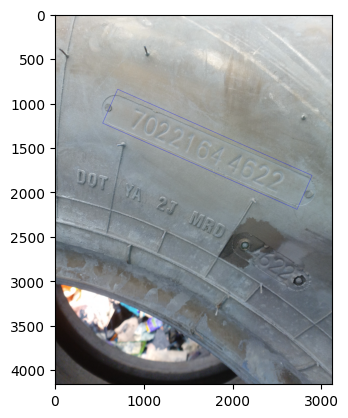

In [ ]:
img=result.orig_img
plt.imshow(img)
rect = cv.minAreaRect(cnt)
box = cv.boxPoints(rect)
box = np.int0(box)
plt.imshow(cv.drawContours(img,[box],0,(0,0,255),2))

In [ ]:
box

array([[ 534, 1226],
       [ 703,  845],
       [2885, 1815],
       [2716, 2196]])

In [ ]:
w=int(math.dist(box[0],box[1]))
h=int(math.dist(box[1],box[2]))
w,h

(416, 2387)

In [ ]:

def row_sum(box):
    return np.sum(box)
min_sum_index = min(range(len(box)), key=lambda i: row_sum(box[i]))

if (w<h):
  box = np.roll(box,-1,axis=0)
  min_sum_index-= 1
  print(box)


[[ 703  845]
 [2885 1815]
 [2716 2196]
 [ 534 1226]]


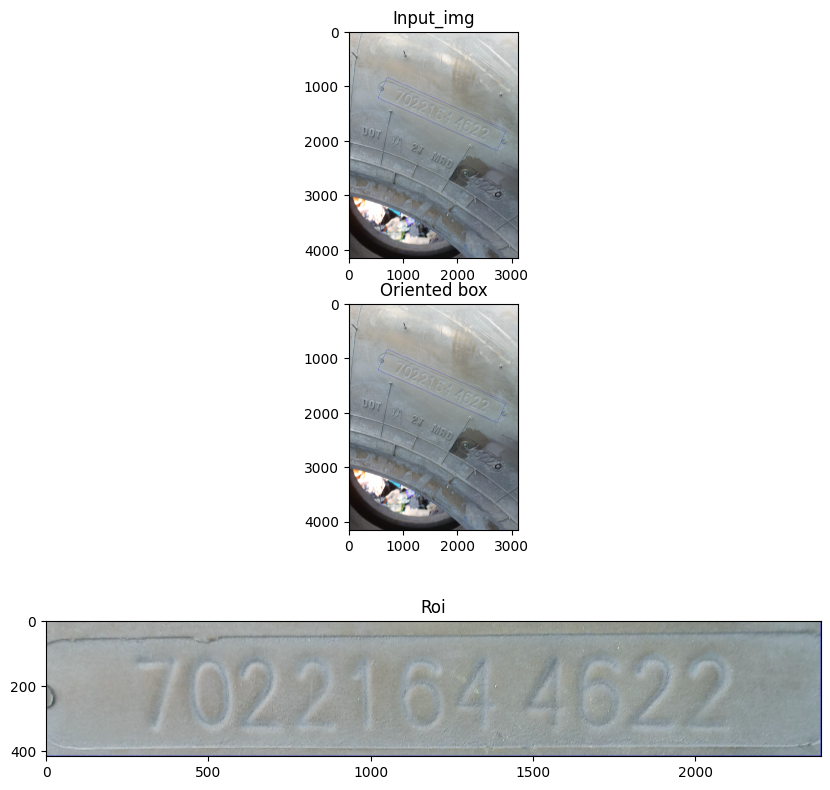

In [ ]:
w=int(math.dist(box[0],box[1]))
h=int(math.dist(box[1],box[2]))
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.title('Input_img')
plt.imshow(input_img)
plt.subplot(3,1,2)
plt.title('Oriented box')
plt.imshow(img)
point1=np.float32(box)
point2=np.float32([[0,0],[w,0],[w,h],[0,h]])
M=cv.getPerspectiveTransform(point1,point2)
roi=cv.warpPerspective(img,M,(w,h))
plt.subplot(3, 1, 3)
plt.title("Roi")
plt.imshow(roi)

In [ ]:
'''
def rename_images(folder_path):
    # Change directory to the folder containing images
    os.chdir(folder_path)

    # Get a list of image files in the directory
    image_files = [f for f in os.listdir() if os.path.isfile(f) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]


    # Rename the image files to sequential numbers
    for idx, image_file in enumerate(image_files, start=1):
        file_extension = os.path.splitext(image_file)[1]
        new_filename = str(idx) + file_extension

        # Rename the file
        os.rename(image_file, new_filename)
        print(f"Renamed {image_file} to {new_filename}")

# Replace 'folder_path' with the path to the directory containing your images
folder_path = '/content/drive/MyDrive/original_tyre'
rename_images(folder_path)'''


'\ndef rename_images(folder_path):\n    # Change directory to the folder containing images\n    os.chdir(folder_path)\n\n    # Get a list of image files in the directory\n    image_files = [f for f in os.listdir() if os.path.isfile(f) and f.lower().endswith((\'.png\', \'.jpg\', \'.jpeg\', \'.gif\', \'.bmp\'))]\n\n\n    # Rename the image files to sequential numbers\n    for idx, image_file in enumerate(image_files, start=1):\n        file_extension = os.path.splitext(image_file)[1]\n        new_filename = str(idx) + file_extension\n\n        # Rename the file\n        os.rename(image_file, new_filename)\n        print(f"Renamed {image_file} to {new_filename}")\n\n# Replace \'folder_path\' with the path to the directory containing your images\nfolder_path = \'/content/drive/MyDrive/original_tyre\'\nrename_images(folder_path)'

In [ ]:
'''# Function to get ROI and save images with the same image name in the output folder
def get_save_roi(input_folder, output_folder):
    model = YOLO('/content/drive/MyDrive/yolov8-seg/segment/train2/weights/best.pt')

    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Check for image files
            file_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            result = model(file_path, save=True, save_txt=True)[0]
            if result.masks==None:
              print('roi not find')
              continue
            else :
              result=model(file_path,save=True,save_txt=True,conf=float('{:.2f}'.format(result[0].boxes.conf.item()))-0.01)[0]

            #input_img=result.orig_img
            o_path = f"{result.save_dir}/{filename}"
            masked_img = plt.imread(o_path)
            H,W,_=masked_img.shape
            for j, mask in enumerate(result.masks.data):
                mask = mask.cpu().numpy() * 255
                mask = cv.resize(mask, (W, H))
                cv.imwrite('/content/output3.jpg', mask)

            mask = plt.imread('/content/output3.jpg')
            ret, thresh = cv.threshold(mask, 100, 255, 0)
            contours, hierarchy = cv.findContours(thresh, 1, 2)
            max_cnt_index = max(range(len(contours)), key=lambda i: cv.contourArea(contours[i]))
            cnt = contours[max_cnt_index]
            img = result.orig_img

            rect = cv.minAreaRect(cnt)
            box = cv.boxPoints(rect)
            box = np.int0(box)
            w=int(math.dist(box[0],box[1]))
            h=int(math.dist(box[1],box[2]))
            min_sum_index = min(range(len(box)), key=lambda i: np.sum(box[i]))

            if w < h:
                box = np.roll(box, -1, axis=0)
                min_sum_index -= 1

            w = int(math.dist(box[0], box[1]))
            h = int(math.dist(box[1], box[2]))

            point1 = np.float32(box)
            point2 = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
            M = cv.getPerspectiveTransform(point1, point2)
            roi = cv.warpPerspective(img, M, (w, h))

            cv.imwrite(output_path, roi)
            print(f"ROI saved for {filename} in {output_path}")

# Replace 'input_folder' and 'output_folder' with the paths to your input and output directories respectively
input_folder = '/content/drive/MyDrive/original_tyre'
output_folder = '/content/croped_images'

get_save_roi(input_folder, output_folder)'''



image 1/1 /content/drive/MyDrive/original_tyre/1.jpg: 480x640 1 roi, 291.1ms
Speed: 5.5ms preprocess, 291.1ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict11
1 label saved to runs/segment/predict11/labels

image 1/1 /content/drive/MyDrive/original_tyre/1.jpg: 480x640 1 roi, 290.4ms
Speed: 5.0ms preprocess, 290.4ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict11
1 label saved to runs/segment/predict11/labels
ROI saved for 1.jpg in /content/croped_images/1.jpg

image 1/1 /content/drive/MyDrive/original_tyre/2.jpg: 480x640 2 rois, 295.5ms
Speed: 4.9ms preprocess, 295.5ms inference, 10.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict11
2 labels saved to runs/segment/predict11/labels

image 1/1 /content/drive/MyDrive/original_tyre/2.jpg: 480x640 1 roi, 188.7ms
Speed: 3.9ms preprocess, 188.7ms inference, 4.1ms postprocess per image at sha

In [ ]:
#%mkdir /content/croped_images

In [ ]:
#!cp -r "/content/croped_images" "/content/drive/MyDrive/croped_images"

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mCv1Kn9A5JWfzvFbhPAO")
project = rf.workspace("iit-kgp-xmsnm").project("tyre-text-nuycr")
dataset = project.version(1).download("yolov8")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstall

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.235, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to tyre-text-1 in yolov8:: 100%|██████████| 641/641 [00:00<00:00, 6669.43it/s]


In [ ]:
model_t = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 98.7MB/s]


In [ ]:
results = model_t.train(data='/content/tyre-text-1/data.yaml', epochs=100, imgsz=640)

Ultralytics YOLOv8.0.235 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/tyre-text-1/data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    751507  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
Model summary: 225 layers, 3011043 parameters, 3011027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train2', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/tyre-text-1/train/labels... 278 images, 0 backgrounds, 0 corrupt: 100%|██████████| 278/278 [00:00<00:00, 1972.63it/s]

train: New cache created: /content/tyre-text-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/tyre-text-1/valid/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 1257.30it/s]

val: New cache created: /content/tyre-text-1/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.69G      2.358      2.592      2.069        117        640: 100%|██████████| 18/18 [00:13<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all         28        245        0.5      0.412      0.412      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.24G      1.528      1.216       1.39         80        640: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         28        245        0.8      0.753      0.835      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.21G      1.528      1.136      1.386         83        640: 100%|██████████| 18/18 [00:05<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         28        245       0.79      0.646      0.765      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.21G      1.464       1.06      1.351        107        640: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         28        245      0.793      0.751      0.817      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.2G       1.44      1.053       1.36         55        640: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         28        245      0.717       0.71      0.752      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.2G      1.457     0.9929      1.339        112        640: 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         28        245      0.924      0.898      0.959      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.23G      1.407      0.975      1.315         74        640: 100%|██████████| 18/18 [00:05<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         28        245      0.951      0.878      0.946       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.19G      1.375     0.9346      1.301         77        640: 100%|██████████| 18/18 [00:05<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         28        245      0.901      0.927      0.959      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.23G      1.403     0.9482      1.328         87        640: 100%|██████████| 18/18 [00:06<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         28        245      0.758      0.837      0.791      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.2G      1.366     0.9313      1.303         72        640: 100%|██████████| 18/18 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         28        245      0.858      0.943      0.945      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.23G      1.346     0.8963      1.301        130        640: 100%|██████████| 18/18 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         28        245       0.86      0.796      0.861       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.2G      1.353     0.8848       1.33         74        640: 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         28        245      0.969      0.935      0.976      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.23G      1.355     0.8496      1.311        120        640: 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         28        245       0.94      0.951      0.976      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.23G      1.314     0.8341      1.281         73        640: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         28        245      0.888      0.904      0.951       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.23G      1.328     0.8164      1.286        112        640: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         28        245      0.953      0.959      0.979      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.21G       1.35     0.8406      1.307         98        640: 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         28        245      0.909      0.849      0.929      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.25G      1.298     0.8034      1.287         98        640: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         28        245      0.969      0.959      0.985      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.22G      1.251     0.7797      1.255         66        640: 100%|██████████| 18/18 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         28        245      0.963      0.949       0.98      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.22G      1.262     0.7702      1.268        129        640: 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         28        245       0.95      0.936      0.977      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.23G      1.258     0.7751       1.26         93        640: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         28        245       0.92      0.943      0.968      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.22G      1.322      0.791      1.287         73        640: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         28        245       0.86      0.829      0.888      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.21G      1.279     0.7686      1.257         89        640: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         28        245       0.92      0.898      0.964      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.22G      1.242      0.754      1.245         69        640: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         28        245      0.975      0.947      0.985      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.2G       1.26     0.7415      1.249         67        640: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         28        245      0.959      0.946      0.976       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.23G      1.232     0.7211       1.24         69        640: 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         28        245       0.97      0.922       0.98      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.2G      1.204      0.709      1.233        109        640: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         28        245      0.967      0.976      0.986      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.21G      1.258     0.7255      1.259         64        640: 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         28        245      0.949      0.988      0.987      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.23G      1.225     0.7031      1.227        110        640: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         28        245      0.977      0.976       0.99      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.22G      1.189     0.6828      1.219         73        640: 100%|██████████| 18/18 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         28        245       0.96      0.977      0.981      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.22G      1.202     0.6969      1.235         88        640: 100%|██████████| 18/18 [00:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         28        245      0.957      0.959      0.979       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.21G      1.189     0.6882      1.242         81        640: 100%|██████████| 18/18 [00:07<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         28        245      0.956      0.943      0.969      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.21G      1.155      0.674      1.215        100        640: 100%|██████████| 18/18 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         28        245      0.963      0.959      0.974      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.23G      1.163     0.6707      1.213         86        640: 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         28        245      0.975      0.968      0.983      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.2G      1.134     0.6528      1.182         77        640: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         28        245      0.925       0.95      0.968      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.21G      1.152     0.6589      1.203         68        640: 100%|██████████| 18/18 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         28        245      0.984      0.967      0.984      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.21G       1.18     0.6534      1.218        136        640: 100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         28        245      0.978      0.967       0.98      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.23G      1.185     0.6628      1.215         83        640: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         28        245      0.979      0.959      0.981      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.21G      1.159     0.6458      1.215         97        640: 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         28        245      0.969      0.963      0.979      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.22G      1.134     0.6417      1.202        121        640: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         28        245      0.979      0.955      0.984      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.2G       1.15     0.6344      1.209        100        640: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         28        245       0.99      0.976      0.986      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.2G       1.13     0.6139      1.193        112        640: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         28        245      0.984      0.976      0.985      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.23G      1.176     0.6368      1.197        102        640: 100%|██████████| 18/18 [00:06<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         28        245      0.961      0.967      0.987      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.23G      1.152     0.6301      1.208         76        640: 100%|██████████| 18/18 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         28        245       0.96      0.974      0.981      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.21G      1.156     0.6332      1.206         98        640: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         28        245      0.975      0.971      0.981      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.23G      1.104     0.6088       1.18        128        640: 100%|██████████| 18/18 [00:06<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         28        245      0.972      0.959      0.976      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.2G      1.074     0.5939      1.161         66        640: 100%|██████████| 18/18 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         28        245      0.985      0.963      0.985      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.22G      1.072     0.5942      1.167        105        640: 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         28        245      0.971      0.959      0.975      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.21G      1.123     0.6064       1.19         63        640: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         28        245      0.975      0.951      0.976      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.21G      1.099     0.6095      1.171        120        640: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         28        245      0.983      0.972      0.984      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.2G      1.084     0.5983      1.158        102        640: 100%|██████████| 18/18 [00:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         28        245      0.983       0.97      0.985       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.22G      1.085     0.5848      1.168         99        640: 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         28        245      0.986      0.976      0.984      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.2G       1.07     0.5844       1.16         81        640: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         28        245      0.975      0.963      0.989      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.21G      1.085     0.5934      1.149        128        640: 100%|██████████| 18/18 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         28        245      0.979       0.97      0.982      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.22G      1.064     0.5933      1.155         71        640: 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         28        245      0.982      0.976      0.984      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.21G      1.053     0.5785      1.147         84        640: 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         28        245       0.98      0.975      0.985      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.2G      1.055     0.5632      1.144         84        640: 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         28        245      0.965      0.959      0.974      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.22G      1.048     0.5869      1.148        101        640: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         28        245      0.984      0.967      0.978      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.21G      1.015     0.5647      1.145         66        640: 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         28        245      0.979      0.971      0.979      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.23G      1.033       0.57      1.134        101        640: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         28        245      0.974       0.93       0.97      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.19G       1.01     0.5511      1.123        108        640: 100%|██████████| 18/18 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         28        245      0.979      0.951      0.973      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.21G      1.004     0.5355       1.13        120        640: 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         28        245      0.983      0.963      0.984       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.2G      1.019     0.5564       1.13         80        640: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         28        245      0.975      0.963      0.978      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.23G      1.028      0.548      1.149         84        640: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         28        245      0.983      0.952      0.981      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.2G      1.036     0.5599      1.136        103        640: 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         28        245      0.979      0.967      0.988      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.2G     0.9891     0.5366       1.12         86        640: 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         28        245      0.996      0.967      0.985      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.23G     0.9911     0.5297      1.126         56        640: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         28        245      0.992      0.979      0.987      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.21G      0.985     0.5353      1.106         74        640: 100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         28        245      0.987      0.971      0.987      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.2G     0.9927     0.5341      1.128         95        640: 100%|██████████| 18/18 [00:05<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         28        245      0.979      0.973      0.981       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.22G     0.9838     0.5377      1.109         68        640: 100%|██████████| 18/18 [00:05<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         28        245      0.987      0.976      0.984      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.19G     0.9839     0.5329      1.113         89        640: 100%|██████████| 18/18 [00:06<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         28        245      0.992      0.975      0.992      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.22G     0.9594     0.5233      1.106         83        640: 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         28        245      0.988       0.98      0.993      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.18G      0.943     0.5292      1.114         70        640: 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         28        245      0.979       0.97      0.982      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.23G     0.9579     0.5204      1.102         82        640: 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         28        245      0.991      0.967      0.983      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.2G     0.9546     0.5052      1.099         86        640: 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         28        245       0.99      0.971      0.985      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.23G     0.9573     0.5017      1.093        103        640: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         28        245      0.998      0.971      0.979       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.21G     0.9539     0.5142      1.105        129        640: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         28        245      0.989      0.963      0.985      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.3G     0.9423     0.5142      1.084         68        640: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         28        245      0.992      0.971      0.983      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.21G     0.9516     0.5186      1.107        127        640: 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         28        245      0.996      0.975      0.985      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.21G     0.9318     0.4974      1.092        112        640: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         28        245       0.99      0.976      0.979      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.23G     0.9256     0.4996      1.086        112        640: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         28        245      0.992      0.966      0.981      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.21G     0.9257     0.4988      1.091         77        640: 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         28        245          1      0.975      0.986      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.22G     0.9399     0.5068      1.093        115        640: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         28        245      0.983      0.973      0.986      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.2G     0.8908     0.4855      1.067         97        640: 100%|██████████| 18/18 [00:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         28        245      0.983      0.962      0.978      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       2.2G     0.9311     0.5153      1.079         64        640: 100%|██████████| 18/18 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         28        245      0.986      0.963      0.984      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.22G     0.8841     0.4843      1.056        118        640: 100%|██████████| 18/18 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         28        245      0.992      0.975      0.979      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.2G     0.8934     0.4862      1.073         58        640: 100%|██████████| 18/18 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         28        245      0.988      0.971      0.986      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.23G     0.8722     0.4886       1.08         45        640: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         28        245      0.992      0.974      0.985      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.23G      0.857     0.4672      1.054         88        640: 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         28        245      0.992      0.979      0.986      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.22G     0.8651       0.47      1.049         85        640: 100%|██████████| 18/18 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         28        245      0.989      0.976      0.987      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.21G      0.835     0.4537      1.042         71        640: 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         28        245      0.987      0.976      0.987      0.617


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.58G     0.8012     0.4529       1.07         50        640: 100%|██████████| 18/18 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         28        245      0.985      0.971      0.979      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.3G     0.7895      0.434      1.047         57        640: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         28        245      0.981      0.971       0.98      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.3G     0.7671     0.4295      1.052         58        640: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         28        245       0.99      0.971      0.981      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.3G      0.783     0.4221      1.048         47        640: 100%|██████████| 18/18 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         28        245      0.987      0.967      0.976      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       2.3G     0.7825     0.4237      1.039         58        640: 100%|██████████| 18/18 [00:05<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         28        245      0.983      0.971       0.98      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.3G     0.7546     0.4211      1.035         41        640: 100%|██████████| 18/18 [00:04<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         28        245      0.983      0.976      0.982      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.3G     0.7502     0.4113      1.032         51        640: 100%|██████████| 18/18 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         28        245       0.99      0.967      0.979       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.3G     0.7342     0.4136      1.029         52        640: 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         28        245      0.991      0.971       0.98      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.29G     0.7383     0.4117      1.016         51        640: 100%|██████████| 18/18 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         28        245      0.994      0.971      0.983       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.29G     0.7291     0.4069      1.008         48        640: 100%|██████████| 18/18 [00:05<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         28        245      0.994      0.971      0.984      0.614



100 epochs completed in 0.205 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.235 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


                   all         28        245      0.996      0.975      0.985      0.633
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
path='/content/tyre-text-1/test/images/79_jpg.rf.105811f11c746c8474969f5fc77e4b07.jpg'
result=model_t(path,save=True,save_txt=True,conf=0.5)[0]


image 1/1 /content/tyre-text-1/test/images/79_jpg.rf.105811f11c746c8474969f5fc77e4b07.jpg: 640x640 7 chars, 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train220
1 label saved to runs/detect/train220/labels


In [ ]:
cropped_img=plt.imread(path)
o_path=f"{result.save_dir}/{path.split('/')[-1]}"
bbx_img=plt.imread(o_path)

Text(0.5, 1.0, 'bbx_img')

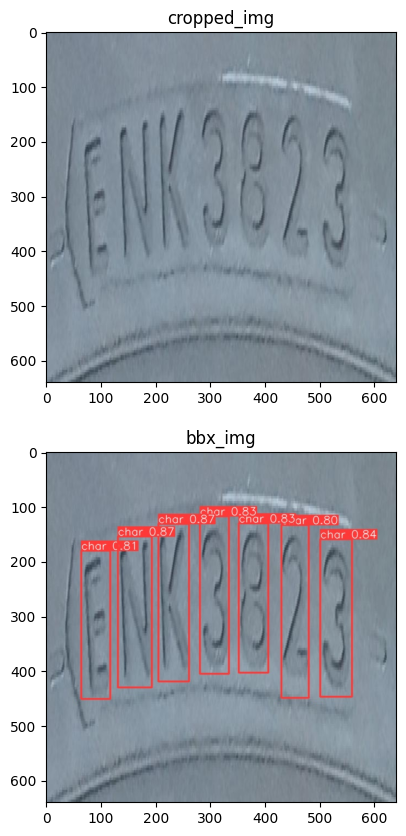

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(cropped_img)
plt.title('cropped_img')
plt.subplot(2,1,2)
plt.imshow(bbx_img)
plt.title('bbx_img')